# Playground for SLM Phase Patterns

**Discription:** This Notebook generates phase patterns for the Spatial Light Modulator (SLM). <br>
**Author(s):** *M. Fränzl and N. Söker*

## Required Packages

In [1]:
import numpy as np
pi = np.pi
import matplotlib.pyplot as plt
%matplotlib inline

from skimage.transform import resize
from skimage.util import invert 

# Package need to export 16 bit TIF images
import tifffile as tiff 
# Windows: If you get an error with "pip install tifffile" install the Build Tools for Visual Studio (https://visualstudio.microsoft.com/downloads/)

from scipy.fftpack import fft2, ifft2, fftshift, ifftshift

## SLM and Setup Settings

Setup the parameters for the SLM and the setup

In [2]:
# Dimension of the SLM in pixel
dimx = 512
dimy = 512
# Pixel pitch in micrometer
pitch = 15
# Wavelength in nanometer
lda = 532

x, y = np.meshgrid(np.arange(dimx), np.arange(dimy))

## Grating Phase Pattern (XY Displacement)

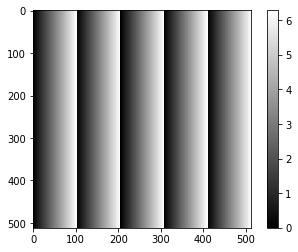

In [3]:
# Grating periods in ???
g_x = 10;
g_y = 0;
phase_grating = np.mod(pi*g_x/dimx*x + pi*g_y/dimy*y, 2*pi);

#plt.imshow(im, cmap='gray')
plt.imshow(phase_grating, cmap='gray', vmin=0, vmax=2*pi)
plt.colorbar()
plt.show()

In [4]:
# Convert phase to 16 bit 
phase_grating = phase_grating/(2*pi)*65535 # 2**16 - 1

### Fresnel Lens Phase Pattern (Focusing)

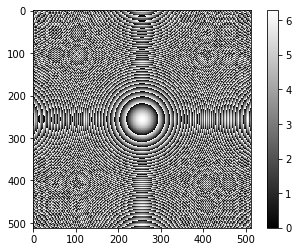

In [5]:
# Focal length in mm
f = -300
phase_fresnel = np.mod(pi/(lda*1e-9*f*1e-3)*((x - dimx/2)**2 + (y - dimy/2)**2)*(pitch*1e-6)**2, 2*pi)

plt.imshow(phase_fresnel, cmap='gray', vmin=0, vmax=2*pi)
plt.colorbar()
plt.show()

In [6]:
# Convert phase to 16 bit 
phase_fresnel = phase_fresnel/(2*pi)*65535 # 2**16 - 1

## Load the Image you want to Display with the SLM

In [7]:
def FFT(x):
    return fftshift(fft2(ifftshift(x), axes=(0,1)), axes=(0,1))

def iFFT(x):
    return fftshift(ifft2(ifftshift(x, axes=(0,1)), axes=(0,1)), axes=(0,1))

In [8]:
def phase(u):
    return np.arctan2(np.imag(u), np.real(u))

### Gerchberg–Saxton (GS) Algorithm

In [9]:
slm_size = 512
x0 = y0 = slm_size/2
nx = ny = 5
dx = dy = 32
x, y = np.meshgrid(np.arange(0, nx*dx, dx) + x0 - (nx-1)*dx/2, np.arange(0, ny*dy, dy) + y0 - (ny-1)*dy/2)

x = x.flatten()
y = y.flatten()
z = np.zeros(x.size)
I = np.ones(x.size)

image = np.zeros((slm_size, slm_size))
image[x.astype(int), y.astype(int)] = 1

#plt.figure(figsize=(5,5))
#plt.scatter(x, y, s=50, c=I, cmap='gray_r')
#plt.xlim(0, slm_size)
#plt.ylim(0, slm_size)
#plt.clim(0, 1)
#plt.colorbar()

plt.imshow(image*np.sum(A_laser)/(nx*ny), extent=[0, slm_size, 0, slm_size], cmap='gray')
plt.colorbar()

NameError: name 'A_laser' is not defined

In [ ]:
np.sum(A_laser)/(nx*ny)

In [ ]:
A_laser = np.ones((slm_size, slm_size))
A_desired = image*np.sum(A_laser)/(nx*ny)
a = 0.5
n = 0
U_slm = (np.random.rand(slm_size, slm_size) + 1j*np.random.rand(slm_size, slm_size)) # np.random.rand(slm_size, slm_size) # FFT(A_desired)
while n < 10:
    U_target = FFT(A_laser*np.exp(1j*phase(U_slm)))
    #A = np.abs(U_target)
    U_slm = iFFT(A_desired*np.exp(1j*phase(U_target)))
    #U_slm = iFFT((a*A_desired + (1-a)*A/np.max(A))*np.exp(1j*phase(U_target)))
    #U_slm = iFFT((a*A_desired**2/A/np.max(A) + (1-a)*A_desired)*np.exp(1j*phase(U_target)))
    n += 1

#plt.figure(figsize=(5,5))
plt.imshow(phase(U_slm), cmap='gray')
plt.colorbar()
plt.show()

In [ ]:
# wavelength*f_lense/pixel_size
#x_size = y_size = 532e-9*0.3/15e-6*1e3

plt.figure(figsize=(8,6))

im = FFT(np.exp(1j*phase(U_slm)))
plt.imshow(np.abs(im), extent=[0, slm_size, 0, slm_size], cmap='gray')

#m_y, m_x = np.where(np.abs(im) > 2000)
#plt.plot(m_x, m_y, 'o', mfc='none', c='red') # extent=[0, dimx, 0, dimy], 
plt.xlabel('x [mm]')
plt.ylabel('y [mm]')
plt.colorbar()

In [ ]:
# Convert phase from -pi, pi to 0, 2*pi
phase_image = phase(U_slm) + np.pi
# Convert phase to 16 bit 
phase_image = phase_image/(2*pi)*65535 # 2**16 - 1

## Add all Phase Images

In [ ]:
#phase_total = np.mod(phase_grating, 2**16)
#phase_total = np.mod(phase_fresnel, 2**16)
#phase_total = np.mod(phase_grating + phase_fresnel, 2**16)
#phase_total = np.mod(phase_image, 2**16)
phase_total = np.mod(phase_image + phase_fresnel, 2**16)
#phase_total = np.mod(phase_grating + phase_fresnel + phase_image, 2**16)

In [ ]:
plt.imshow(phase_total, cmap='gray')
plt.colorbar()
plt.show()

In [ ]:
# Save image as 16 bit TIF file
tiff.imsave('5x5_Grid_-300mm.tiff', phase_total.astype('uint16')) # resolution=(72,72)

In [ ]:
np.sum(A_laser)/np.sum(np.abs(im)[x.astype(int), y.astype(int)])

In [ ]:
slm_size = 512
x, y = np.meshgrid(np.arange(255-128, 255+127+64, 64), np.arange(255-128, 255+127+64, 64))
x = x.flatten()
y = y.flatten()
z = np.zeros(x.size)
I = np.ones(x.size)

In [ ]:
image = np.zeros((slm_size, slm_size))
image[x, y] = 1

In [ ]:
plt.imshow(image, cmap='gray')
m_y, m_x = np.where(np.abs(image) > 0.5)
plt.plot(m_x, m_y, 'o', mfc='none', c='red') # extent=[0, dimx, 0, dimy], 
plt.colorbar()

In [ ]:
slm_size = 64
x, y = np.meshgrid(np.arange(32-16, 32+16+8, 8), np.arange(32-16, 32+16+8, 8))
x = x.flatten()
y = y.flatten()
z = np.zeros(x.size)
I = np.ones(x.size)

plt.figure(figsize=(5,5))
plt.scatter(x, y, s=50, c=I, cmap='gray_r')
plt.xlim(0, slm_size)
plt.ylim(0, slm_size)
plt.clim(0, 1)
#plt.colorbar()

In [ ]:
image = np.zeros((slm_size, slm_size))+0.00001
image[x, y] = 1.

In [ ]:
A_laser = np.ones((slm_size, slm_size))
A_desired = image
a = 0.5
n = 0
U_slm = (np.random.rand(slm_size, slm_size) + 1j*np.random.rand(slm_size, slm_size)) # np.random.rand(slm_size, slm_size) # FFT(A_desired)
while n < 10:
    U_target = FFT(A_laser*np.exp(1j*phase(U_slm)))
    A = np.abs(U_target)
    U_slm = iFFT(A_desired*np.exp(1j*phase(U_target)))
    #U_slm = iFFT((a*A_desired + (1-a)*A/np.max(A))*np.exp(1j*phase(U_target)))
    #U_slm = iFFT((a*A_desired**2/A/np.max(A) + (1-a)*A_desired)*np.exp(1j*phase(U_target)))
    n += 1

In [ ]:
plt.imshow(phase(U_slm), cmap='gray')
plt.colorbar()
plt.show()

In [ ]:
# wavelength*f_lense/pixel_size
#x_size = y_size = 532e-9*0.3/15e-6*1e3

plt.figure(figsize=(8,8))

im = FFT(np.exp(1j*phase(U_slm)))
plt.imshow(np.abs(im), extent=[0, slm_size, 0, slm_size], cmap='gray')

m_y, m_x = np.where(np.abs(im) > 2000)
plt.plot(m_x, m_y, 'o', mfc='none', c='red') # extent=[0, dimx, 0, dimy], 
plt.xlabel('x [mm]')
plt.ylabel('y [mm]')
#plt.colorbar()

In [ ]:
A_laser = np.ones((slm_size, slm_size))
A_desired = image
n = 0
U_slm = (np.random.rand(slm_size, slm_size) + 1j*np.random.rand(slm_size, slm_size)) # np.random.rand(slm_size, slm_size) # FFT(A_desired)
w_prev = A_desired
#A_prev = A_desired # np.ones((slm_size, slm_size))
while n < 10:
    U_target = FFT(A_laser*np.exp(1j*phase(U_slm)))
    w = w_prev*A_desired/np.abs(U_target)
    #w = w_prev*np.mean(A_prev)/A_prev
    U_slm = iFFT(w*np.exp(1j*phase(U_target)))
    w_prev = w
    #A_prev = np.abs(U_target)
    n += 1

In [ ]:
plt.imshow(phase(U_slm), cmap='gray')
plt.colorbar()
plt.show()

In [ ]:
# wavelength*f_lense/pixel_size
#x_size = y_size = 532e-9*0.3/15e-6*1e3

plt.figure(figsize=(8,8))

im = FFT(np.exp(1j*phase(U_slm)))
plt.imshow(np.abs(im), extent=[0, slm_size, 0, slm_size], cmap='gray')

m_y, m_x = np.where(np.abs(im) > 2000)
plt.plot(m_x, m_y, 'o', mfc='none', c='red') # extent=[0, dimx, 0, dimy], 
plt.xlabel('x [mm]')
plt.ylabel('y [mm]')
#plt.colorbar()

In [ ]:
# Convert phase from -pi, pi to 0, 2*pi
phase_image = phase(A) + np.pi
# Convert phase to 16 bit 
phase_image = phase_image/(2*pi)*65535 # 2**16 - 1

## Add all Phase Images

In [ ]:
#phase_total = np.mod(phase_grating, 2**16)
#phase_total = np.mod(phase_fresnel, 2**16)
phase_total = np.mod(invert(phase_image), 2**16)
#phase_total = np.mod(phase_grating + phase_fresnel, 2**16)
#phase_total = np.mod(phase_grating + phase_fresnel + phase_image, 2**16)

In [ ]:
plt.imshow(phase_total, cmap='gray')
plt.colorbar()
plt.show()

In [ ]:
# Save image as 16 bit TIF file
tiff.imsave('Total_Phase.tiff', phase_total.astype('uint16')) # resolution=(72,72)